##### Get a boundary of data to read from, to match OSM region data

In [1]:
import pyrosm

/mnt/c/Users/Alfred/CLionProjects/outbreak-sim/python/venv/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Get London's OpenStreetMap data
fp = pyrosm.get_data("London", update=True)
print(fp)
# Initialize the OSM object 
osm = pyrosm.OSM(fp)

Downloaded Protobuf data 'London.osm.pbf' (71.06 MB) to:
'/tmp/pyrosm/London.osm.pbf'
/tmp/pyrosm/London.osm.pbf


<AxesSubplot:>

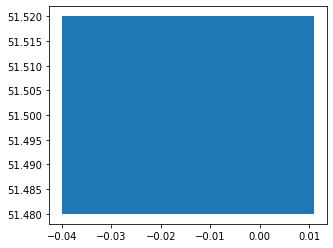

In [3]:
# # Read all boundaries using the default settings
# boundaries = osm.get_boundaries()

# # pick a small subset for testing
# boundary = osm.get_boundaries(name="London Borough of Tower Hamlets")
# boundary.plot()

import geopandas as gpd
from shapely.geometry import box

bbox = box(-0.04, 51.48, 0.011, 51.52)  # a random box around a part of Tower Hamlets and Canary Wharf
boundary = gpd.GeoDataFrame({'geometry': bbox}, index=[0])
boundary.plot()

##### Load WorldPop Dataset and transform to match boundary

In [4]:
import geopandas as gpd
import rasterio
import rioxarray as rxr
from matplotlib import pyplot as plt

In [67]:
uk_wp = rxr.open_rasterio('../data/gbr_ppp_2020_UNadj_constrained.tif', masked=True).squeeze()
uk_wp.rio.crs  # make sure the crs is EPSG:4326 (WGS84) to match the unprojected OSM boundary

CRS.from_epsg(4326)

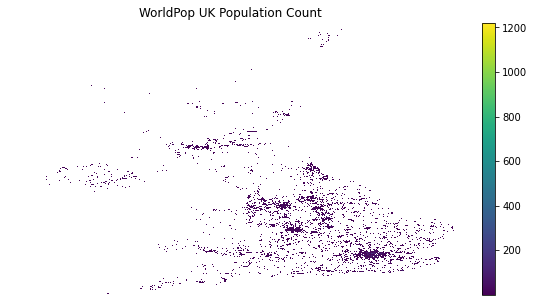

In [6]:
f, ax = plt.subplots(figsize=(10, 5))
uk_wp.plot.imshow()
ax.set(title="WorldPop UK Population Count")

ax.set_axis_off()
plt.show()

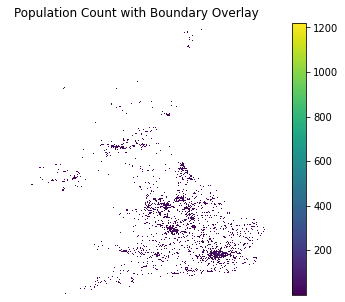

In [7]:
f, ax = plt.subplots(figsize=(10, 5))
uk_wp.plot.imshow(ax=ax)

boundary.plot(ax=ax, alpha=.8)
ax.set(title="Population Count with Boundary Overlay")

ax.set_axis_off()
plt.show()

In [66]:
import pyrosm
from pathlib import Path
fp = pyrosm.get_data("Greater London",
                     directory='../data/osm_pbf_data',
#                      update=True
                    )
osm = pyrosm.OSM(fp)
boundaries = osm.get_boundaries()
boundary = osm.get_boundaries(name="Greater London")

In [68]:
from shapely.geometry import mapping
from rasterio.crs import CRS
from rasterio.enums import Resampling

greater_london = uk_wp.rio.clip(boundary.geometry.apply(mapping))

Text(0.5, 1.0, '')

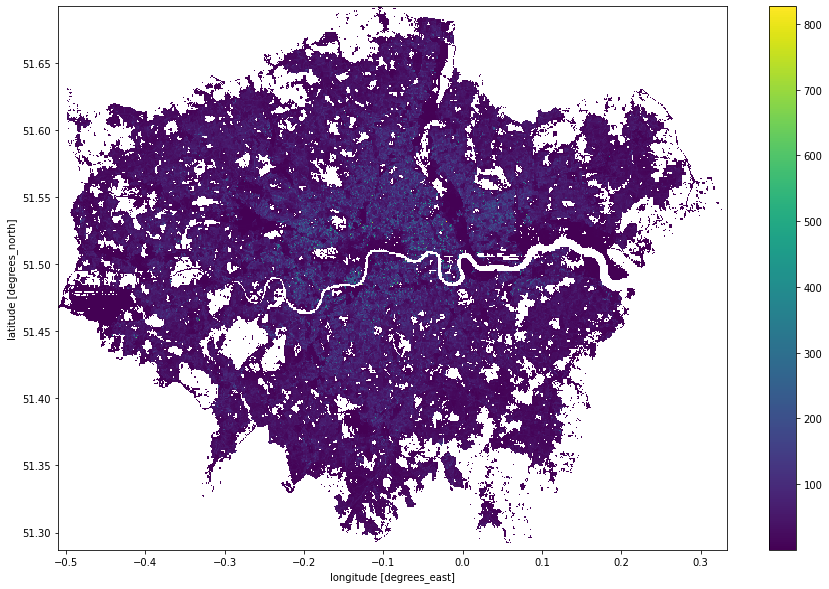

In [72]:
fig, ax = plt.subplots(figsize=(15, 10))
greater_london.plot.imshow(ax=ax)
fig.gca().set_title("")

In [74]:
fig.savefig('london_pop', bbox_inches='tight', pad_inches=0.1)

In [8]:
from shapely.geometry import mapping
from rasterio.crs import CRS
from rasterio.enums import Resampling

wp_clipped = uk_wp.rio.clip(boundary.geometry.apply(mapping))
default = wp_clipped.rio.reproject(dst_crs=CRS.from_epsg(27700))
bilinear = wp_clipped.rio.reproject(dst_crs=CRS.from_epsg(27700), resampling=Resampling.bilinear)
cubic = wp_clipped.rio.reproject(dst_crs=CRS.from_epsg(27700), resampling=Resampling.cubic)
average = wp_clipped.rio.reproject(dst_crs=CRS.from_epsg(27700), resampling=Resampling.average)
cubic_spline = wp_clipped.rio.reproject(dst_crs=CRS.from_epsg(27700), resampling=Resampling.cubic_spline)
lanczos = wp_clipped.rio.reproject(dst_crs=CRS.from_epsg(27700), resampling=Resampling.lanczos)
nearest = wp_clipped.rio.reproject(dst_crs=CRS.from_epsg(27700), resampling=Resampling.nearest)
q1 = wp_clipped.rio.reproject(dst_crs=CRS.from_epsg(27700), resampling=Resampling.q1)
q3 = wp_clipped.rio.reproject(dst_crs=CRS.from_epsg(27700), resampling=Resampling.q3)

In [9]:
print(f"Unprojected: {float(wp_clipped.sum())}")
print(f"Default: {float(default.sum())}")
print(f"Bilinear: {float(bilinear.sum())}")
print(f"Cubic: {float(cubic.sum())}")
print(f"Average: {float(average.sum())}")
print(f"Cubic Spline: {float(cubic_spline.sum())}")
print(f"Lanczos: {float(lanczos.sum())}")
print(f"Nearest: {float(nearest.sum())}")
print(f"Q1: {float(q1.sum())}")
print(f"Q3: {float(q3.sum())}")

Unprojected: 157168.05750638247
Default: 157662.81565451622
Bilinear: 157911.31037489232
Cubic: 157659.65722343902
Average: 176702.79656888993
Cubic Spline: 157892.53842165045
Lanczos: 154483.9308274052
Nearest: 157662.81565451622
Q1: 111463.94641679525
Q3: 206542.3299563527


(0.0, 1.0, 0.0, 1.0)

<Figure size 432x288 with 0 Axes>

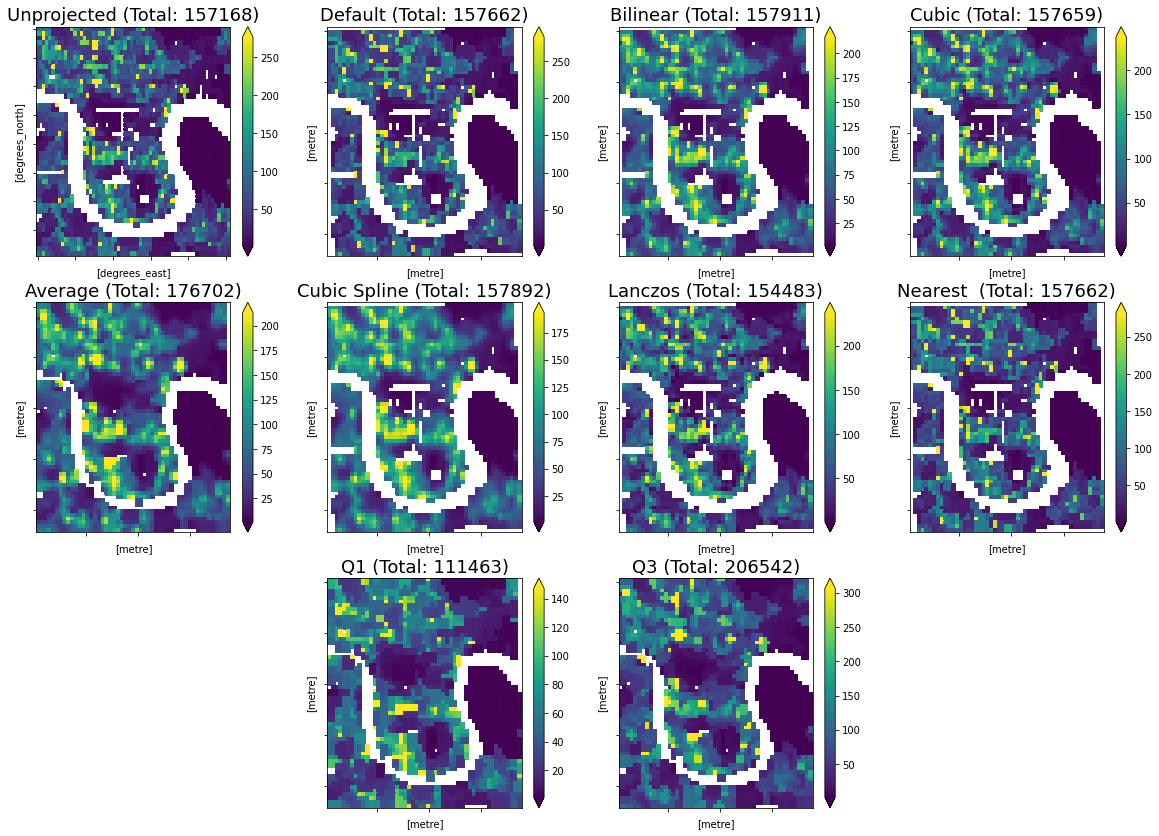

In [64]:
plt.tight_layout()
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 14))
# fig.suptitle('Different Sampling methods when Projecting a Population Raster', fontsize=25)
plt.subplots_adjust(top=0.90)

def plot_on_ax(data, ax, title):
    data.plot(ax=ax, cmap='viridis', robust=True)
    ax.set_title(f"{title} (Total: {int(data.sum())})", size=18)
    x_label = ax.get_xlabel()
    y_label = ax.get_ylabel()
    ax.set_xlabel(x_label[x_label.find('['):])
    ax.set_ylabel(y_label[y_label.find('['):])
    ax.set_yticklabels([])
    ax.set_xticklabels([])

plot_on_ax(wp_clipped, ax[0, 0], 'Unprojected')
plot_on_ax(default, ax[0, 1], 'Default')
plot_on_ax(bilinear, ax[0, 2], 'Bilinear')
plot_on_ax(cubic, ax[0, 3], 'Cubic')
plot_on_ax(average, ax[1, 0], 'Average')
plot_on_ax(cubic_spline, ax[1, 1], 'Cubic Spline')
plot_on_ax(lanczos, ax[1, 2], 'Lanczos')
plot_on_ax(nearest, ax[1, 3], 'Nearest ')
ax[2, 0].axis('off')
plot_on_ax(q1, ax[2, 1], 'Q1')
plot_on_ax(q3, ax[2, 2], 'Q3')
ax[2, 3].axis('off')

In [65]:
fig.savefig('projections', bbox_inches='tight', pad_inches=0)

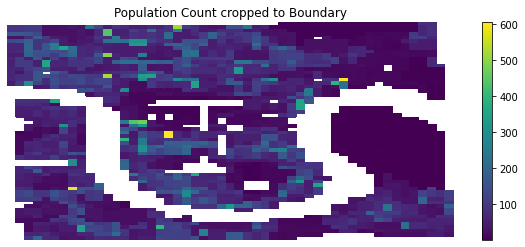

In [13]:
from shapely.geometry import mapping
from rasterio.crs import CRS

wp_clipped = uk_wp.rio.clip(boundary.geometry.apply(mapping))
wp_clipped = wp_clipped.rio.reproject(dst_crs=CRS.from_epsg(27700))

f, ax = plt.subplots(figsize=(10, 4))
wp_clipped.plot(ax=ax)
ax.set(title="Population Count cropped to Boundary")
ax.set_axis_off()
plt.show()

In [14]:
wp_clipped.sum()

<xarray.DataArray ()>
array(157662.81565452)
Coordinates:
    band         int64 1
    spatial_ref  int64 0